In [6]:
# scarches_xenium_adapt.py
# Run with: python scarches_xenium_adapt.py
# Requires: scanpy, anndata, torch, numpy, scipy, scikit-learn

import os
import math
import random
from typing import Optional

import numpy as np
import scipy.sparse as sp
import anndata as ad
import scanpy as sc
from sklearn.neighbors import NearestNeighbors

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Phase-0: Data Loading and pre-processing

In [7]:
# ---------------------------
# USER: set these file paths if different
# ---------------------------
XEN_H5AD = "../Graph_SCModal/SmallData/xenium_reference_common_genes.h5ad"
REF_H5AD = "../Graph_SCModal/SmallData/xenium_spatial_common_genes.h5ad"
OUTDIR = "scarches_xenium_out"
os.makedirs(OUTDIR, exist_ok=True)

In [8]:
# ---------------------------
# LOADING THE DATA
# ---------------------------

adata_ref = sc.read_h5ad(REF_H5AD)  # Query dataset (to annotate)
adata_xen = sc.read_h5ad(XEN_H5AD)  # Reference dataset (with labels)

In [9]:
adata_ref.var_names_make_unique()
adata_xen.var_names_make_unique()

In [10]:
# ---------------------------------------------------
# 1.2 Extract sets of observed cell types
# ---------------------------------------------------

label_col_A = "cell_type"  # Label column in reference dataset
label_col_B = "celltype_major"  # Label column in query dataset

types_A = set(adata_ref.obs[label_col_A].astype(str))
types_B = set(adata_xen.obs[label_col_B].astype(str))

print("\nNumber of label categories:")
print("A:", len(types_A))
print("B:", len(types_B))


Number of label categories:
A: 20
B: 9


In [11]:
# ---------------------------------------------------
# 1.3 Map intersection
# ---------------------------------------------------
print(types_A)
print(types_B)

# Mapping Xenium A (fine) → B (broad)
mapping_A_to_B = mapping = {
    # Lymphoid
    'B_Cells': 'B-cells',
    'CD4+_T_Cells': 'T-cells',
    'CD8+_T_Cells': 'T-cells',
    'Stromal_&_T_Cell_Hybrid': 'T-cells',
    'T_Cell_&_Tumor_Hybrid': 'T-cells',

    # Myeloid
    'Macrophages_1': 'Myeloid',
    'Macrophages_2': 'Myeloid',
    'Mast_Cells': 'Myeloid',
    'IRF7+_DCs': 'Myeloid',
    'LAMP3+_DCs': 'Myeloid',
    'TFR+_DCs': 'Myeloid',

    # Epithelial
    'Invasive_Tumor': 'Cancer Epithelial',
    'Prolif_Invasive_Tumor': 'Cancer Epithelial',
    'DCIS_1': 'Cancer Epithelial',
    'DCIS_2': 'Cancer Epithelial',
    'Myoepi_ACTA2+': 'Normal Epithelial',
    'Myoepi_KRT15+': 'Normal Epithelial',

    # Endothelial
    'Endothelial': 'Endothelial',
    'Perivascular-Like': 'Endothelial',

    # Stromal
    'Stromal': 'CAFs',

    # Unlabeled / others
    'Unlabeled': 'Unlabeled'
}


# Apply mapping
adata_ref.obs["broad_cell_type"] = adata_ref.obs["cell_type"].map(mapping_A_to_B)

# Verify mapping success
print(adata_ref.obs["broad_cell_type"].value_counts(dropna=False))

{'Unlabeled', 'Endothelial', 'Macrophages_2', 'DCIS_2', 'B_Cells', 'Macrophages_1', 'DCIS_1', 'IRF7+_DCs', 'Prolif_Invasive_Tumor', 'Invasive_Tumor', 'Stromal', 'Myoepi_KRT15+', 'CD8+_T_Cells', 'LAMP3+_DCs', 'Stromal_&_T_Cell_Hybrid', 'CD4+_T_Cells', 'Myoepi_ACTA2+', 'T_Cell_&_Tumor_Hybrid', 'Perivascular-Like', 'Mast_Cells'}
{'PVL', 'CAFs', 'B-cells', 'T-cells', 'Myeloid', 'Endothelial', 'Normal Epithelial', 'Cancer Epithelial', 'Plasmablasts'}
broad_cell_type
Cancer Epithelial    752
CAFs                 496
T-cells              177
Myeloid              175
Normal Epithelial    125
Endothelial          124
Unlabeled             89
B-cells               62
Name: count, dtype: int64


In [12]:
# ---------------------------------------------------------
# 2. Identify common genes
# ---------------------------------------------------------

genes_A = np.array(adata_ref.var_names).astype(str)
genes_B = np.array(adata_xen.var_names).astype(str)

common_genes = np.intersect1d(genes_A, genes_B)

print(f"\nNumber of shared genes: {len(common_genes)}")
print("Example shared genes:", common_genes[:10])

if len(common_genes) == 0:
    raise ValueError("No overlapping genes found between A and B!")

# ---------------------------------------------------------
# 3. Subset both datasets using only common genes
# ---------------------------------------------------------

# It is critical that gene order matches in both datasets
A_common = adata_ref[:, common_genes].copy()
B_common = adata_xen[:, common_genes].copy()

# Sort gene order identically in both
sorted_genes = np.sort(common_genes)

adata_ref = A_common[:, sorted_genes].copy()
adata_xen = B_common[:, sorted_genes].copy()

print("\nAfter subsetting:")
print("A_common shape:", adata_ref.shape)
print("B_common shape:", adata_xen.shape)



Number of shared genes: 308
Example shared genes: ['ABCC11' 'ACTA2' 'ACTG2' 'ADAM9' 'ADGRE5' 'ADH1B' 'ADIPOQ' 'AGR3' 'AHSP'
 'AIF1']

After subsetting:
A_common shape: (2000, 308)
B_common shape: (2000, 308)


In [13]:
# ---------------------------
# Hyperparameters
# ---------------------------
SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 256
LATENT_DIM = 20
ENC_HIDDEN = [512, 256]
DEC_HIDDEN = [256, 512]
LR = 1e-3
EPOCHS_REF = 40
EPOCHS_ADAPT = 80
WEIGHT_DECAY = 1e-6

# Loss weights (tune these)
BETA_KL = 0.01           # weight for KL
ALPHA_MMD = 1.0          # weight for MMD distribution matching
GAMMA_SPATIAL = 0.5      # weight for spatial smoothing
DELTA_SURGERY = 1e-3     # L2 distance to reference encoder params

# KNN spatial graph parameter for spatial regularizer
SPATIAL_K = 8


In [14]:
# ---------------------------
# Reproducibility
# ---------------------------
def set_seed(s):
    random.seed(s)
    np.random.seed(s)
    torch.manual_seed(s)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(s)
set_seed(SEED)


In [15]:
# ---------------------------
# Utilities for AnnData -> tensors
# ---------------------------
def adata_to_matrix(adata: ad.AnnData):
    """Return dense numpy array for X (cells x genes)."""
    X = adata.X
    if sp.issparse(X):
        X = X.toarray()
    return X.astype(np.float32)

def get_shared_genes(adata_ref, adata_xen):
    shared = np.intersect1d(adata_ref.var_names, adata_xen.var_names)
    return shared

# ---------------------------
# Dataset classes
# ---------------------------
class GeneExpressionDataset(Dataset):
    def __init__(self, X: np.ndarray, labels: Optional[np.ndarray] = None, coords: Optional[np.ndarray] = None):
        self.X = X
        self.labels = labels
        self.coords = coords
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        item = {"x": self.X[idx]}
        if self.labels is not None:
            item["y"] = self.labels[idx]
        if self.coords is not None:
            item["coords"] = self.coords[idx]
        return item

In [16]:
# ---------------------------
# Model: simple VAE encoder/decoder and classifier head
# ---------------------------
def build_mlp(layer_sizes, activation=nn.ReLU, last_activation=None):
    layers = []
    for i in range(len(layer_sizes)-1):
        layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
        if i < len(layer_sizes)-2:  # not last
            layers.append(activation())
        elif last_activation is not None:
            layers.append(last_activation())
    return nn.Sequential(*layers)

class Encoder(nn.Module):
    def __init__(self, n_input, hidden_sizes, latent_dim):
        super().__init__()
        sizes = [n_input] + hidden_sizes + [latent_dim*2]  # outputs mu and logvar concatenated
        self.net = build_mlp(sizes, activation=nn.ReLU)
    def forward(self, x):
        h = self.net(x)
        mu, logvar = torch.chunk(h, 2, dim=1)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_sizes, n_output):
        super().__init__()
        sizes = [latent_dim] + hidden_sizes + [n_output]
        self.net = build_mlp(sizes, activation=nn.ReLU, last_activation=nn.Identity)
    def forward(self, z):
        return self.net(z)

class VAE(nn.Module):
    def __init__(self, n_genes, enc_hidden, dec_hidden, latent_dim):
        super().__init__()
        self.encoder = Encoder(n_genes, enc_hidden, latent_dim)
        self.decoder = Decoder(latent_dim, dec_hidden, n_genes)
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z)
        return recon, mu, logvar, z

In [17]:
# ---------------------------
# Loss functions
# ---------------------------
def recon_loss_poisson(recon_logits, x):
    # Using Gaussian MSE on log1p counts is simpler; use MSE
    return F.mse_loss(recon_logits, x, reduction='mean')

def kl_divergence(mu, logvar):
    # KL(N(mu, var) || N(0,1))
    return -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

# MMD with RBF kernel
def compute_pairwise_dist(x, y):
    # x: (n, d), y: (m, d)
    xx = (x**2).sum(1).reshape(-1,1)
    yy = (y**2).sum(1).reshape(1,-1)
    dist = xx + yy - 2.0 * (x @ y.t())
    return dist

def rbf_kernel(x, y, sigmas=None):
    if sigmas is None:
        sigmas = [1.0, 2.0, 4.0, 8.0]
    dist = compute_pairwise_dist(x, y)
    K = 0.0
    for s in sigmas:
        gamma = 1.0 / (2.0 * s)
        K = K + torch.exp(-gamma * dist)
    return K

def mmd_rbf(x, y, sigmas=None):
    K_xx = rbf_kernel(x, x, sigmas)
    K_yy = rbf_kernel(y, y, sigmas)
    K_xy = rbf_kernel(x, y, sigmas)
    m = x.shape[0]
    n = y.shape[0]
    # unbiased estimate
    out = K_xx.sum() / (m*m) + K_yy.sum() / (n*n) - 2.0 * K_xy.sum() / (m*n)
    return out

def spatial_smoothing_loss(z, edge_index):
    # edge_index: (2, E) numpy or torch tensor of node pairs
    # encourage neighbors to have similar z
    if isinstance(edge_index, np.ndarray):
        edge_index = torch.from_numpy(edge_index).to(z.device)
    src, dst = edge_index
    diff = z[src] - z[dst]
    return torch.mean(torch.sum(diff**2, dim=1))


In [18]:
# ---------------------------
# Helpers: create spatial KNN graph for Xenium
# ---------------------------
def build_knn_edges(coords, k=8):
    # coords: (n_cells, 2) or more
    neigh = NearestNeighbors(n_neighbors=k+1, algorithm='auto', metric='euclidean').fit(coords)
    distances, indices = neigh.kneighbors(coords)
    n = coords.shape[0]
    src_list = []
    dst_list = []
    for i in range(n):
        nbrs = indices[i, 1:]  # skip self
        for j in nbrs:
            src_list.append(i)
            dst_list.append(int(j))
    edge_index = np.vstack([np.array(src_list), np.array(dst_list)])
    return edge_index

In [19]:
# ---------------------------
# Training loops
# ---------------------------
def train_vae_reference(model: VAE, dataloader, epochs, device):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    model.train()
    for ep in range(1, epochs+1):
        total_loss = 0.0
        total_recon = 0.0
        total_kl = 0.0
        n_batches = 0
        for batch in dataloader:
            x = batch["x"].to(device)
            optimizer.zero_grad()
            recon, mu, logvar, z = model(x)
            l_recon = recon_loss_poisson(recon, x)
            l_kl = kl_divergence(mu, logvar)
            loss = l_recon + BETA_KL * l_kl
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_recon += l_recon.item()
            total_kl += l_kl.item()
            n_batches += 1
        if ep % 5 == 0 or ep == 1:
            print(f"[REF] Epoch {ep}/{epochs} | loss {total_loss/n_batches:.4f} | recon {total_recon/n_batches:.4f} | kl {total_kl/n_batches:.4f}")
    return model

def adapt_encoder_query(ref_model: VAE, query_vae: VAE, ref_loader, query_loader, coords_edge_index, epochs, device):
    # We will freeze ref_model's parameters
    ref_model.to(device).eval()
    query_vae.to(device).train()
    # Freeze decoder from reference by copying weights to query decoder and freezing decoder weights
    # SCArches usually freezes decoder and trains query encoder only
    query_vae.decoder.load_state_dict(ref_model.decoder.state_dict())
    for p in query_vae.decoder.parameters():
        p.requires_grad = False

    # Optionally initialize query encoder from ref encoder
    query_vae.encoder.load_state_dict(ref_model.encoder.state_dict())

    # Optimizer: only encoder params of query_vae
    enc_params = [p for p in query_vae.encoder.parameters() if p.requires_grad]
    optimizer = torch.optim.Adam(enc_params, lr=LR*0.5, weight_decay=WEIGHT_DECAY)

    for ep in range(1, epochs+1):
        total = 0.0
        n_batches = 0
        # iterate through query loader (we'll sample reference Z per batch for MMD)
        for qbatch in query_loader:
            xq = qbatch["x"].to(device)
            optimizer.zero_grad()
            # Query forward
            recon_q, mu_q, logvar_q, z_q = query_vae(xq)

            # Reconstruction & KL
            l_recon = recon_loss_poisson(recon_q, xq)
            l_kl = kl_divergence(mu_q, logvar_q)

            # Sample a minibatch of reference latents for MMD:
            try:
                rbatch = next(ref_loader_iter)
            except:
                ref_loader_iter = iter(ref_loader)
                rbatch = next(ref_loader_iter)
            xr = rbatch["x"].to(device)
            with torch.no_grad():
                _, mu_r, logvar_r, z_r = ref_model(xr)

            # MMD between z_r and z_q
            # ensure we have same (or similar) batch sizes
            min_bs = min(z_r.shape[0], z_q.shape[0])
            z_r_sub = z_r[:min_bs]
            z_q_sub = z_q[:min_bs]
            l_mmd = mmd_rbf(z_r_sub, z_q_sub)

            # Spatial smoothing (for query)
            if coords_edge_index is not None:
                l_spatial = spatial_smoothing_loss(z_q, coords_edge_index)
            else:
                l_spatial = torch.tensor(0.0, device=device)

            # Surgery L2: distance between encoder params (query vs ref)
            l_surgery = torch.tensor(0.0, device=device)
            for p_q, p_r in zip(query_vae.encoder.parameters(), ref_model.encoder.parameters()):
                l_surgery = l_surgery + torch.sum((p_q - p_r)**2)
            l_surgery = l_surgery / 2.0  # scale

            loss = l_recon + BETA_KL * l_kl + ALPHA_MMD * l_mmd + GAMMA_SPATIAL * l_spatial + DELTA_SURGERY * l_surgery
            loss.backward()
            optimizer.step()

            total += loss.item()
            n_batches += 1
        if ep % 5 == 0 or ep == 1:
            print(f"[ADAPT] Epoch {ep}/{epochs} | avg loss {total/n_batches:.4f}")
    return query_vae

In [20]:
# ---------------------------
# Classifier training (supervised on reference latents)
# ---------------------------
class Classifier(nn.Module):
    def __init__(self, latent_dim, n_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, n_classes)
        )
    def forward(self, z):
        return self.net(z)

def train_classifier_on_reference(ref_model: VAE, classifier: Classifier, ref_loader, epochs, device):
    ref_model.to(device).eval()
    classifier.to(device).train()
    optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    for ep in range(1, epochs+1):
        total_loss = 0.0
        n = 0
        for batch in ref_loader:
            x = batch["x"].to(device)
            y = batch["y"].to(device).long()
            with torch.no_grad():
                _, mu, logvar, z = ref_model(x)
            logits = classifier(z.detach())
            loss = criterion(logits, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            n += 1
        if ep % 5 == 0 or ep == 1:
            print(f"[CLS] Epoch {ep}/{epochs} | loss {total_loss/n:.4f}")
    return classifier

def predict_query_labels(query_vae: VAE, classifier: Classifier, query_loader, device):
    query_vae.to(device).eval()
    classifier.to(device).eval()
    preds = []
    probs = []
    with torch.no_grad():
        for batch in query_loader:
            x = batch["x"].to(device)
            _, mu, logvar, z = query_vae(x)
            logits = classifier(z)
            p = F.softmax(logits, dim=1).cpu().numpy()
            pred = logits.argmax(dim=1).cpu().numpy()
            preds.append(pred)
            probs.append(p)
    preds = np.concatenate(preds, axis=0)
    probs = np.concatenate(probs, axis=0)
    return preds, probs

In [21]:
# ---------------------------
# Main: wiring everything
# ---------------------------

print("Loading AnnData objects...")
adata_ref = sc.read_h5ad(REF_H5AD)
adata_xen = sc.read_h5ad(XEN_H5AD)

# user said they already did this but we repeat for safety
shared_genes = get_shared_genes(adata_ref, adata_xen)
if len(shared_genes) < 10:
    raise ValueError("Too few shared genes; check var_names.")
print(f"Shared genes: {len(shared_genes)}")

# subset both AnnData objects
adata_ref = adata_ref[:, shared_genes].copy()
adata_xen = adata_xen[:, shared_genes].copy()

# Mapping Xenium A (fine) → B (broad)
mapping_A_to_B = mapping = {
    # Lymphoid
    'B_Cells': 'B-cells',
    'CD4+_T_Cells': 'T-cells',
    'CD8+_T_Cells': 'T-cells',
    'Stromal_&_T_Cell_Hybrid': 'T-cells',
    'T_Cell_&_Tumor_Hybrid': 'T-cells',

    # Myeloid
    'Macrophages_1': 'Myeloid',
    'Macrophages_2': 'Myeloid',
    'Mast_Cells': 'Myeloid',
    'IRF7+_DCs': 'Myeloid',
    'LAMP3+_DCs': 'Myeloid',
    'TFR+_DCs': 'Myeloid',

    # Epithelial
    'Invasive_Tumor': 'Cancer Epithelial',
    'Prolif_Invasive_Tumor': 'Cancer Epithelial',
    'DCIS_1': 'Cancer Epithelial',
    'DCIS_2': 'Cancer Epithelial',
    'Myoepi_ACTA2+': 'Normal Epithelial',
    'Myoepi_KRT15+': 'Normal Epithelial',

    # Endothelial
    'Endothelial': 'Endothelial',
    'Perivascular-Like': 'Endothelial',

    # Stromal
    'Stromal': 'CAFs',

    # Unlabeled / others
    'Unlabeled': 'Unlabeled'
}


# Apply mapping
adata_ref.obs["broad_cell_type"] = adata_ref.obs["cell_type"].map(mapping_A_to_B)

# --- Preprocessing (simple) ---
# assume raw counts — log1p transform & scale to unit variance (common practice)
sc.pp.normalize_total(adata_ref, target_sum=1e4)
sc.pp.log1p(adata_ref)
sc.pp.scale(adata_ref)

sc.pp.normalize_total(adata_xen, target_sum=1e4)
sc.pp.log1p(adata_xen)
sc.pp.scale(adata_xen)

X_ref = adata_to_matrix(adata_ref)  # (n_ref, n_genes)
X_xen = adata_to_matrix(adata_xen)  # (n_xen, n_genes)

# Labels for reference (required for classifier training) - user must have 'cell_type' or similar
if 'broad_cell_type' not in adata_ref.obs:
    raise KeyError("Please ensure adata_ref.obs contains 'broad_cell_type' column for supervised classifier training.")
labels_ref = adata_ref.obs['broad_cell_type'].astype('category').cat.codes.values
label_categories = adata_ref.obs['broad_cell_type'].astype('category').cat.categories
n_classes = len(label_categories)
print(f"Number of classes in ref: {n_classes}")

# Query coords (for spatial smoothing) - if not available, coords_edge_index = None
coords = None
if 'x' in adata_xen.obsm.keys() and 'y' in adata_xen.obsm.keys():
    coords = np.vstack([adata_xen.obsm['x'], adata_xen.obsm['y']]).T
elif 'spatial' in adata_xen.obsm:
    # 10x Visium style
    coords = adata_xen.obsm['spatial']
else:
    # try common keys
    if 'X_spatial' in adata_xen.obsm:
        coords = adata_xen.obsm['X_spatial']
if coords is None:
    print("No spatial coordinates found in adata_xen.obsm — spatial smoothing will be skipped.")
    coords_edge_index = None
else:
    print("Building KNN spatial graph for xenium...")
    coords_edge_index = build_knn_edges(coords, k=SPATIAL_K)
    # Move to torch once later

# Build dataloaders
ref_ds = GeneExpressionDataset(X_ref, labels_ref)
query_ds = GeneExpressionDataset(X_xen, labels=None, coords=coords)
ref_loader = DataLoader(ref_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
query_loader = DataLoader(query_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

# Build models
n_genes = X_ref.shape[1]
ref_vae = VAE(n_genes, ENC_HIDDEN, DEC_HIDDEN, LATENT_DIM)
print("Training reference VAE on scRNA reference...")
ref_vae = train_vae_reference(ref_vae, ref_loader, EPOCHS_REF, DEVICE)
torch.save(ref_vae.state_dict(), os.path.join(OUTDIR, "ref_vae.pth"))

# Prepare query VAE object (we will copy decoder weights and adapt encoder)
query_vae = VAE(n_genes, ENC_HIDDEN, DEC_HIDDEN, LATENT_DIM)
print("Adapting query encoder with SCArches-style surgery and distribution matching...")
# For spatial, convert edge index into torch indices with respect to each batch: spatial smoothing uses z and edges
# Here we will pass full graph edges and compute smoothing using z from a batch by indexing into z.
coords_edge_index_torch = None
if coords_edge_index is not None:
    coords_edge_index_torch = torch.from_numpy(coords_edge_index).long().to(DEVICE)

adapted_query_vae = adapt_encoder_query(ref_vae, query_vae, ref_loader, query_loader, coords_edge_index_torch, EPOCHS_ADAPT, DEVICE)
torch.save(adapted_query_vae.state_dict(), os.path.join(OUTDIR, "adapted_query_vae.pth"))

# Train classifier on reference latents
print("Training classifier on reference latent space...")
clf = Classifier(LATENT_DIM, n_classes)
ref_loader_with_labels = DataLoader(ref_ds, batch_size=BATCH_SIZE, shuffle=True)
clf = train_classifier_on_reference(ref_vae, clf, ref_loader_with_labels, epochs=30, device=DEVICE)
torch.save(clf.state_dict(), os.path.join(OUTDIR, "classifier.pth"))

# Predict labels for xenium (query)
print("Predicting labels on xenium...")
query_loader_eval = DataLoader(query_ds, batch_size=BATCH_SIZE, shuffle=False)
preds, probs = predict_query_labels(adapted_query_vae, clf, query_loader_eval, DEVICE)

# Save predictions back into adata_xen.obs
adata_xen.obs['pred_cell_type_code'] = preds
# map back to category names
cat_map = {i: c for i, c in enumerate(label_categories)}
adata_xen.obs['pred_cell_type'] = [cat_map[int(i)] for i in preds]

# save probabilities per class as .obsm
adata_xen.obsm['pred_cell_type_probs'] = probs

out_h5ad = os.path.join(OUTDIR, "xenium_with_preds.h5ad")
adata_xen.write(out_h5ad)
print(f"Saved annotated xenium AnnData -> {out_h5ad}")
print("Done.")

Loading AnnData objects...
Shared genes: 308


/Users/zehaannaik/Course Work/SEM-7/CS690/Xenium_Annotation_CS690/.venv/lib/python3.10/site-packages/legacy_api_wrap/__init__.py:88: UserWarning: Some cells have zero counts
  return fn(*args_all, **kw)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/functools.py:889: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/functools.py:889: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


Number of classes in ref: 8
No spatial coordinates found in adata_xen.obsm — spatial smoothing will be skipped.
Training reference VAE on scRNA reference...
[REF] Epoch 1/40 | loss 0.9999 | recon 0.9993 | kl 0.0664
[REF] Epoch 5/40 | loss 0.8511 | recon 0.8416 | kl 0.9476
[REF] Epoch 10/40 | loss 0.7682 | recon 0.7548 | kl 1.3333
[REF] Epoch 15/40 | loss 0.7279 | recon 0.7117 | kl 1.6270
[REF] Epoch 20/40 | loss 0.6791 | recon 0.6589 | kl 2.0122
[REF] Epoch 25/40 | loss 0.6305 | recon 0.6065 | kl 2.4032
[REF] Epoch 30/40 | loss 0.5869 | recon 0.5601 | kl 2.6800
[REF] Epoch 35/40 | loss 0.5509 | recon 0.5219 | kl 2.8916
[REF] Epoch 40/40 | loss 0.5215 | recon 0.4912 | kl 3.0264
Adapting query encoder with SCArches-style surgery and distribution matching...
[ADAPT] Epoch 1/80 | avg loss 0.7660
[ADAPT] Epoch 5/80 | avg loss 0.7397
[ADAPT] Epoch 10/80 | avg loss 0.7345
[ADAPT] Epoch 15/80 | avg loss 0.7332
[ADAPT] Epoch 20/80 | avg loss 0.7315
[ADAPT] Epoch 25/80 | avg loss 0.7302
[ADAPT] 

/Users/zehaannaik/Course Work/SEM-7/CS690/Xenium_Annotation_CS690/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Extracting latent embeddings...
Reference latent shape: (2000, 20)
Xenium latent shape: (2000, 20)


/Users/zehaannaik/Course Work/SEM-7/CS690/Xenium_Annotation_CS690/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


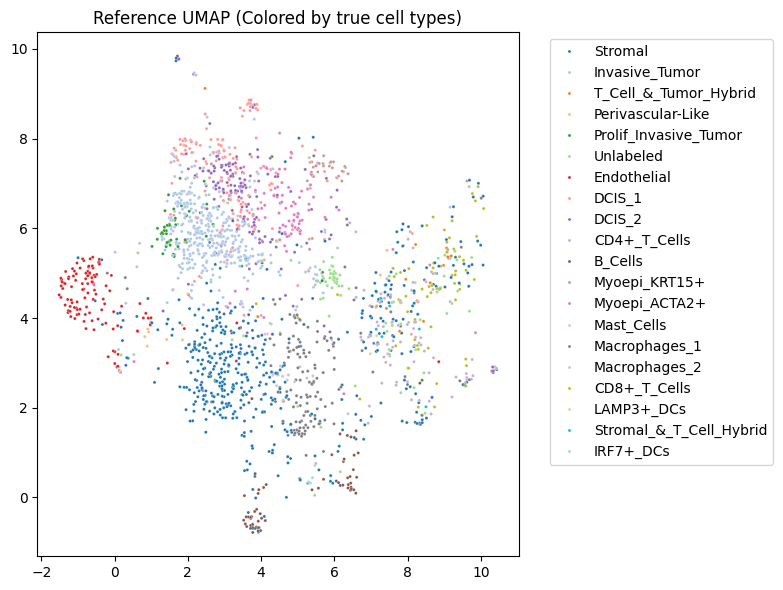

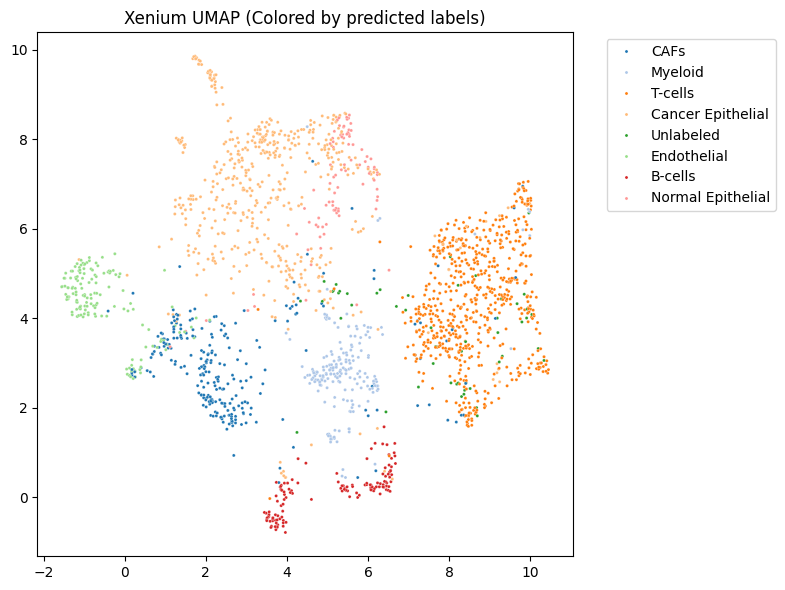

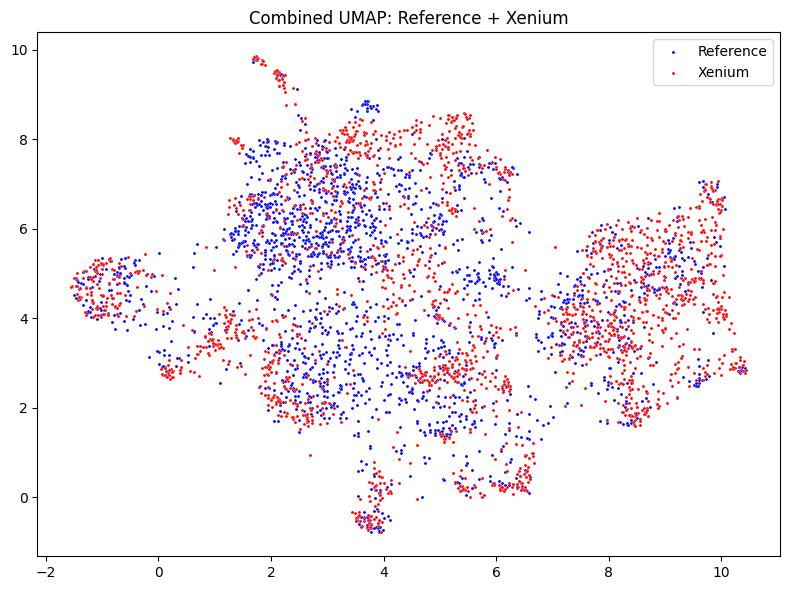


📊 VALIDATION METRICS
Reference accuracy (self-consistency): 0.9110
Reference ARI: 0.8640

Reference Silhouette score: 0.0553
Xenium Silhouette (pred labels): 0.0602

Done!


In [22]:
# ===========================
#   UMAP + Metrics Section
# ===========================
import umap
from sklearn.metrics import adjusted_rand_score, accuracy_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# Extract latent embeddings
# ---------------------------
def get_latents(vae, X, batch_size=512):
    vae.eval()
    zs = []
    with torch.no_grad():
        for i in range(0, X.shape[0], batch_size):
            xb = torch.tensor(X[i:i+batch_size], dtype=torch.float32).to(DEVICE)
            _, mu, logvar, z = vae(xb)
            zs.append(z.cpu().numpy())
    return np.vstack(zs)

print("Extracting latent embeddings...")
Z_ref = get_latents(ref_vae, X_ref)
Z_xen = get_latents(adapted_query_vae, X_xen)

print(f"Reference latent shape: {Z_ref.shape}")
print(f"Xenium latent shape: {Z_xen.shape}")

# ---------------------------
# Run UMAP on concatenated latents
# ---------------------------
Z_all = np.vstack([Z_ref, Z_xen])
um = umap.UMAP(n_neighbors=20, min_dist=0.3, metric='euclidean', random_state=42)
Z_umap = um.fit_transform(Z_all)
Z_ref_umap = Z_umap[:Z_ref.shape[0]]
Z_xen_umap = Z_umap[Z_ref.shape[0]:]

# ---------------------------
# Plotting
# ---------------------------
# 1. UMAP colored by reference labels
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=Z_ref_umap[:,0], y=Z_ref_umap[:,1],
    hue=adata_ref.obs["cell_type"].astype(str),
    s=5, palette="tab20"
)
plt.title("Reference UMAP (Colored by true cell types)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# 2. UMAP colored by predicted xenium labels
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=Z_xen_umap[:,0], y=Z_xen_umap[:,1],
    hue=adata_xen.obs["pred_cell_type"].astype(str),
    s=5, palette="tab20"
)
plt.title("Xenium UMAP (Colored by predicted labels)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# 3. Combined plot: ref + query
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=Z_ref_umap[:,0], y=Z_ref_umap[:,1],
    color="blue", s=5, label="Reference"
)
sns.scatterplot(
    x=Z_xen_umap[:,0], y=Z_xen_umap[:,1],
    color="red", s=5, label="Xenium"
)
plt.title("Combined UMAP: Reference + Xenium")
plt.legend()
plt.tight_layout()
plt.show()

# --------------------------------------------------
#   VALIDATION METRICS
# --------------------------------------------------

print("\n==========================")
print("📊 VALIDATION METRICS")
print("==========================")

# ---------------------------
# (A) Reference Label Accuracy (Classifier sanity check)
# ---------------------------
# Predict labels on ref
ref_preds, _ = predict_query_labels(ref_vae, clf,
    DataLoader(ref_ds, batch_size=BATCH_SIZE, shuffle=False),
    DEVICE
)

acc_ref = accuracy_score(labels_ref, ref_preds)
ari_ref = adjusted_rand_score(labels_ref, ref_preds)

print(f"Reference accuracy (self-consistency): {acc_ref:.4f}")
print(f"Reference ARI: {ari_ref:.4f}")

# ---------------------------
# (C) Silhouette score (global structure)
# ---------------------------
sil_ref = silhouette_score(Z_ref, labels_ref)
print(f"\nReference Silhouette score: {sil_ref:.4f}")

# If xenium has predicted labels, compute silhouette
sil_xen = silhouette_score(Z_xen, adata_xen.obs['pred_cell_type_code'])
print(f"Xenium Silhouette (pred labels): {sil_xen:.4f}")

print("\nDone!")


In [23]:
# ---------------------------
# (B) Xenium Accuracy (only if ground-truth labels exist)
# ---------------------------
if "celltype_major" in adata_xen.obs:
    print("\nXenium ground-truth labels found. Computing accuracy + ARI...")
    true_xen = adata_xen.obs["celltype_major"].astype("category").cat.codes.values
    pred_xen = adata_xen.obs["pred_cell_type_code"].values
    acc_xen = accuracy_score(true_xen, pred_xen)
    ari_xen = adjusted_rand_score(true_xen, pred_xen)
    print(f"Xenium accuracy: {acc_xen:.4f}")
    print(f"Xenium ARI: {ari_xen:.4f}")
else:
    print("\nNo ground-truth Xenium labels found → skipping accuracy")


Xenium ground-truth labels found. Computing accuracy + ARI...
Xenium accuracy: 0.4855
Xenium ARI: 0.7294
